This notebook contains the code and output for training and validation of WBC with masks. It uses the same architecture as the plain WBC, but the dataset that this was trained on would contain masked images too.

**This model has been combined with pRCC and cam-16 to created a weighted ensemble model. So for validation of the improved combined model, kindly refer to the notebooks that are titled
'WBC_1_ensemble_with_masks_and_pretraining.ipnynb',
 'WBC_10_ensemble_with_masks_and_pretraining.ipnynb', 'WBC_50_ensemble_with_masks_and_pretraining.ipnynb', 'WBC_100_ensemble_with_masks_and_pretraining.ipnynb'**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define the paths to your dataset directories

train_dir = '/content/drive/My Drive/WBC_with_mask/WBC_1/train/data'
val_dir = '/content/drive/My Drive/dataset/WBC_100/val/data'

# Image dimensions
img_width, img_height = 575, 575

# Define data transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Load data from the 'train' directory
train_data = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

# Load data from the 'val' directory
val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=4)




In [ ]:
tl = len(train_loader.dataset)
print("Length of the dataset:", tl)

vl = len(val_loader.dataset)
print("Length of the dataset:", vl)


Length of the dataset: 89
Length of the dataset: 1728


In [ ]:
# Define a custom convolutional neural network with residual blocks
class My_CNN(nn.Module):
    def __init__(self):
        super(My_CNN, self).__init__()
        self.in_channels = 64
        self.conv1 = self.conv_block(3, 64, stride=1)
        self.conv2_x = self.residual_block(64, 128, num_blocks=3, stride=2)
        self.conv3_x = self.residual_block(128, 256, num_blocks=4, stride=2)
        self.conv4_x = self.residual_block(256, 256, num_blocks=6, stride=2)
        #self.conv5_x = self.residual_block(512, 512, num_blocks=3, stride=2)
        self.fc = nn.Linear(256, 5)  # Updated fully connected layer input size

    def conv_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def residual_block(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(self.conv_block(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(self.conv_block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        #x = self.conv5_x(x)
        x = nn.functional.avg_pool2d(x, x.size(2))  # Global average pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the basic residual block
class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define the CNN model with two residual blocks
class ResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicResidualBlock, 64, 2)
        self.layer2 = self._make_layer(BasicResidualBlock, 128, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 5)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Initialize the model
net = ResNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an instance of the My_CNN and move it to the GPU if available
net = ResNet().to(device)

# Define loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)

batch_size = 4



In [ ]:
# Training loop
num_epochs = 20
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []
best_test_accuracy = 0.0
best_model_path = 'best_my_wbc_model.pth'

for epoch in range(num_epochs):
    print("started epoch: ", epoch)
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        #print("processing batch")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct / total) * 100
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(val_loader)
    test_accuracy = (correct / total) * 100
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    if test_accuracy > best_test_accuracy:
        # Save the model with the best weights
        best_test_accuracy = test_accuracy
        torch.save(net.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {test_loss:.4f} - Val Acc: {test_accuracy:.2f}%')

torch.save(net.state_dict(), 'my_wbc.pth')

started epoch:  0
Best model saved to best_my_wbc_model.pth
Epoch [1/20] - Train Loss: 1.1826 - Train Acc: 52.81% - Val Loss: 1.9901 - Val Acc: 61.28%
started epoch:  1
Epoch [2/20] - Train Loss: 1.0524 - Train Acc: 60.67% - Val Loss: 1.2368 - Val Acc: 61.28%
started epoch:  2
Best model saved to best_my_wbc_model.pth
Epoch [3/20] - Train Loss: 1.0015 - Train Acc: 62.92% - Val Loss: 1.0890 - Val Acc: 61.34%
started epoch:  3
Epoch [4/20] - Train Loss: 0.9707 - Train Acc: 62.92% - Val Loss: 1.2970 - Val Acc: 35.19%
started epoch:  4
Epoch [5/20] - Train Loss: 1.0162 - Train Acc: 61.80% - Val Loss: 1.1670 - Val Acc: 61.28%
started epoch:  5
Epoch [6/20] - Train Loss: 1.0785 - Train Acc: 58.43% - Val Loss: 1.2154 - Val Acc: 55.56%
started epoch:  6
Epoch [7/20] - Train Loss: 1.0420 - Train Acc: 62.92% - Val Loss: 2.8045 - Val Acc: 43.00%
started epoch:  7
Epoch [8/20] - Train Loss: 1.0228 - Train Acc: 62.92% - Val Loss: 2.8111 - Val Acc: 61.23%
started epoch:  8
Best model saved to best_m

In [ ]:
#note to self: this is the final model. for best model it is under best_my_wbc_model.pth. downloaded to laptop too. use that for future preds
torch.save(net.state_dict(), '/content/drive/My Drive/my_wbc_1.pth')

In [ ]:
print(train_loss_history)
print(test_loss_history)
print(train_accuracy_history)
print(test_accuracy_history)

[1.1825669524462328, 1.0523993463619896, 1.001516184081202, 0.9706658746885217, 1.0162291306516398, 1.0784871344980986, 1.042021535013033, 1.0227816027143728, 0.9801937186199686, 0.8770173865815868, 0.9499168745849443, 1.0132654399975487, 0.874862068373224, 0.8413995815360028, 0.9286207608554674, 0.8998101068579633, 0.9543741008509761, 0.8472671612449314, 0.8887341255727021, 0.7811983357305112]
[1.9901451078605734, 1.2367725815899946, 1.0890095578851524, 1.2970240928784564, 1.1669870571543772, 1.2154473590630073, 2.804549508176192, 2.8111418239719503, 1.0530905793938372, 1.8605964533799797, 9.74738766213327, 1.2716173597059592, 1.0209375240288123, 1.08612676339086, 1.7368799079149202, 3.474498765616402, 1.600002011353219, 0.9688483393854566, 0.8736411043511773, 0.9420470879930589]
[52.80898876404494, 60.67415730337079, 62.92134831460674, 62.92134831460674, 61.79775280898876, 58.42696629213483, 62.92134831460674, 62.92134831460674, 65.1685393258427, 62.92134831460674, 67.41573033707866,

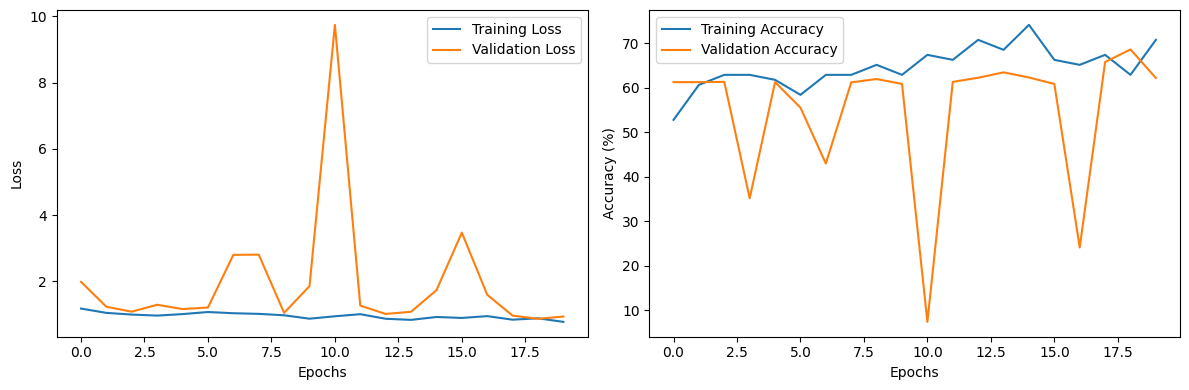

In [ ]:
# Save and display training and testing statistics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_history, label='Training Loss')
plt.plot(range(num_epochs), test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracy_history, label='Training Accuracy')
plt.plot(range(num_epochs), test_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

This notebook contains the code and output for training and validation of WBC with masks. It uses the same architecture as the plain WBC, but the dataset that this was trained on would contain masked images too.

**This model has been combined with pRCC and cam-16 to created a weighted ensemble model. So for validation of the improved combined model, kindly refer to the notebooks that are titled
'WBC_1_ensemble_with_masks_and_pretraining.ipnynb, 'WBC_10_ensemble_with_masks_and_pretraining.ipnynb', 'WBC_50_ensemble_with_masks_and_pretraining.ipnynb', 'WBC_100_ensemble_with_masks_and_pretraining.ipnynb'**